In [107]:
#   !pip install cleantext #only need to do this once (on startup?)

In [3]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from numpy.linalg import norm
from collections import Counter, defaultdict
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import cleantext
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import collections

In [ ]:
# evaluate svd with logistic regression algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

In [74]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

Overview:
For my portion of the group project, I elected to see if I could make kmeans clustering work to:
1.) Identify the 50 authors represented in the per author 50(sample), 50(test) set of exemplar articles by predicting which author cluster of a given test set article would likely belong to by using the kmean "predict" function.

I identified the following steps:

1.) Ingest the data
And after data ingestion populate an appropriate data structure to work with it.
The data set is located at: https://archive.ics.uci.edu/ml/datasets/Reuter_50_50
The training set and the data set are structured similarly:
From a shared set of 50 authors, 50 sample and 50 training article exemplars are provided from each author.

2.) Prepare the data
a.) Clean it up. I experimented with two pre-made Python clean-up functions found at:
https://pypi.org/project/clean-text/
as well as the cleantext function/package found at:
https://pypi.org/project/cleantext/

The clean-text function has as defaults the following flags:

from cleantext import clean
clean("some input",
    fix_unicode=True,               # fix various unicode errors
    to_ascii=True,                  # transliterate to closest ASCII representation
    lower=True,                     # lowercase text
    no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
    no_urls=False,                  # replace all URLs with a special token
    no_emails=False,                # replace all email addresses with a special token
    no_phone_numbers=False,         # replace all phone numbers with a special token
    no_numbers=False,               # replace all numbers with a special token
    no_digits=False,                # replace all digits with a special token
    no_currency_symbols=False,      # replace all currency symbols with a special token
    no_punct=False,                 # remove punctuations
    replace_with_punct="",          # instead of removing punctuations you may replace them
    replace_with_url="<URL>",
    replace_with_email="<EMAIL>",
    replace_with_phone_number="<PHONE>",
    replace_with_number="<NUMBER>",
    replace_with_digit="0",
    replace_with_currency_symbol="<CUR>",
    lang="en"                       # set to 'de' for German special handling
)
    
In the case of clean-text, I used the default settings.
    
Whereas the cleantext function/package has as defaults the following flags:

    To return a list of words from the text,
cleantext.clean_words("your_raw_text_here", all= True) 

To choose a specific set of cleaning operations,

cleantext.clean_words("your_raw_text_here",
all= False # Execute all cleaning operations
extra_spaces=True ,  # Remove extra white space 
stemming=True , # Stem the words
stopwords=True ,# Remove stop words
lowercase=True ,# Convert to lowercase
numbers=True ,# Remove all digits 
punct=True ,# Remove all punctuations
stp_lang='english'  # Language for stop words
)

In the case of cleantext I used the "all-True" flags.

b.)Prepare the test and sample data for injestion by kmeans.
The training data was prepared in two ways:
    1.) Each article was ingested as a list (so, a list of 2500 article-vectors)
    2.) All of the training articles for a given author were ingested into a single list (so, a list of 50 vectors.)
    
    
    I am preparing four cases:
    1.) a cmer-ized version of the 50 and 2500 vector cmer = (2,3,4) 
    2.) a non-cmer-ized version
    (The cmer function is from class.  See definition below.)
    
c.) Vectorize the data
I am using 

If our first author-independent goal is to build a giant vector of possible words from training set, then maybe the correct approach is to sequentially read through all of the different word files and make a set or dictionary of all terms we encounter.  If we build a dictionary, then the word itself can be the key, and each time the word is encuontered the value is updated by 1.

The advantage of doing a dictionary like that would be that we could do a dimensionality reduction on those elements that have entries across many different authors.  We might not want to get rid of text entries that are common for one single author.  So, perhaps the value of each dictionary key would be a 50-tuple with the number of times each word appeared for each author.

Helper functions:

In [4]:
#Helper Functions 1
#Functions Related to cmerization.  (The original from a provided activity, and a wrapper for it.)
def cmer(name, c=3):
    r""" Given a name and parameter c, return the vector of c-mers associated with the name
    """
    #print(len(name),c)
    if c > len(name):
        #print(name)
        #print("c must be less than equal to the character length of ", name)
        return -1
    if c <= 0:
        #print("The integer value of c must be greater than 0")
        return -2
    #I think this is already done in other function name = name.lower()
    v = []
    for i in range(len(name)-c+1):
        v.append(name[i:i+c])    
    return v
#
#
#take a vector of strings and return a vector of cmer-ized length "c" strings
#I wrapped the cmer function, above in a higher level function to always output a single flat vector without errors.
x = ["tes", "bossy", "goodness"]
def cmerize_vector(vector_in,c):
    cmerized_vector = []
    for el in vector_in:
        #print(el)
        if len(el) <= c:
            cmerized_vector.append(el)
        else:
            temp_cmer = cmer(el,c)
            if temp_cmer != -1 and temp_cmer != -2:
                for frag in temp_cmer:
                    cmerized_vector.append(frag)
    return cmerized_vector

In [26]:
x = ['hello', 'goodnight']
cmerize_vector(x,8)

['hello', 'goodnigh', 'oodnight']

In [6]:
#Helper Function 3
#These functions are from the class activity nn-classication
def build_matrix(docs):
    r""" Build sparse matrix from a list of documents, 
    each of which is a list of word/terms in the document.  
    """
    nrows = len(docs) #a "doc" here is a list of words.  
    idx = {}
    tid = 0
    nnz = 0
    for d in docs:
        print(d) #for test
        nnz += len(set(d))
        for w in d:
            if w not in idx:
                idx[w] = tid
                tid += 1
    ncols = len(idx)
        
    # set up memory
    ind = np.zeros(nnz, dtype=np.int)
    val = np.zeros(nnz, dtype=np.double)
    ptr = np.zeros(nrows+1, dtype=np.int)
    i = 0  # document ID / row counter
    n = 0  # non-zero counter
    # transfer values
    for d in docs:
        cnt = Counter(d)
        keys = list(k for k,_ in cnt.most_common())
        l = len(keys)
        for j,k in enumerate(keys):
            ind[j+n] = idx[k]
            val[j+n] = cnt[k]
        ptr[i+1] = ptr[i] + l
        n += l
        i += 1
            
    mat = csr_matrix((val, ind, ptr), shape=(nrows, ncols), dtype=np.double)
    mat.sort_indices()
    
    return mat

def csr_info(mat, name="", non_empty=False):
    r""" Print out info about this CSR matrix. If non_empty, 
    report the number of non-empty rows and cols as well
    """
    if non_empty:
        print("%s [nrows %d (%d non-empty), ncols %d (%d non-empty), nnz %d]" % (
                name, mat.shape[0], 
                sum(1 if mat.indptr[i+1] > mat.indptr[i] else 0 
                for i in range(mat.shape[0])), 
                mat.shape[1], len(np.unique(mat.indices)), 
                len(mat.data)))
    else:
        print( "%s [nrows %d, ncols %d, nnz %d]" % (name, 
                mat.shape[0], mat.shape[1], len(mat.data)) )

def csr_l2normalize(mat, copy=False, **kargs):
    r""" Normalize the rows of a CSR matrix by their L-2 norm. 
    If copy is True, returns a copy of the normalized matrix.
    """
    if copy is True:
        mat = mat.copy()
    nrows = mat.shape[0]
    nnz = mat.nnz
    ind, val, ptr = mat.indices, mat.data, mat.indptr
    # normalize
    for i in range(nrows):
        rsum = 0.0    
        for j in range(ptr[i], ptr[i+1]):
            rsum += val[j]**2
        if rsum == 0.0:
            continue  # do not normalize empty rows
        rsum = 1.0/np.sqrt(rsum)
        for j in range(ptr[i], ptr[i+1]):
            val[j] *= rsum
            
    if copy is True:
        return mat
      
#I am not sure if I like this function, because it returns vectors in place of individual words added to a vector
#Is it better this way?
def namesToMatrix(names, c):
    docs = [cmer(n, c) for n in names]
    print(docs)
    return build_matrix(docs)

#instead of using namesToMatrix(), above, I would prefer to operate on the original set of
#vectors by:
#1.) Removing all elements of length less than n (maybe right after ingest? and before being
#added to the multi-dimension vector?)
#2.) Right after step 1, above, cmerize_vector the vector -- would that make sense?
#3 then continue on with processing, ie, call build_matrix(cmerized vectors)

In [86]:
#Preliminary data ingest (training file names, test file names, author names) operations
import glob
#
#Three container lists for training file paths, test file paths, and author names in both cases:
txtfiles_train = []
txtfiles_test =[]
author_names=[]
#for file in glob.glob("authorship_data/C50/C50train/AaronPressman/*.txt"):
for file in glob.glob("authorship_data/C50/C50train/*/*.txt"):
    txtfiles_train.append(file)
#for file in glob.glob("authorship_data/C50/C50train/AaronPressman/*.txt"):
for file in glob.glob("authorship_data/C50/C50test/*/*.txt"):
    txtfiles_test.append(file)
#print(txtfiles_train)
for dirName in glob.glob("authorship_data/C50/C50train/*/"):
    author_names.append(dirName[29:-1])
#author_words = dict(author_names)
#print(author_names)

In [8]:
print(np.shape(txtfiles_test))
np.shape(txtfiles_train)#this is a test of the sparse matrix generation.  I would like to run it on cleaned up lists of words in each document 

(2500,)


(2500,)

In [9]:
#Build Containers for 3 types of matrices we will us
# Create an empty list, for the words from all articles from each author
list_of_authors_words_Reference = [] #for 50 vectors of words from author training files
list_of_authors_words_Test      = [] #for 2500 vectors for each test article for all authors 
list_of_authors_words_Sample_0   =[] #for 2500 vectors for each training article for all authors
#populate lists with empty 'placeholder' lists for later ingestion
for i in range(50):
    # In each iteration, add an empty list to the main list
    list_of_authors_words_Reference.append([''])
for j in range(2500):#(50-num_in_sample)*50):
    # In each iteration, add an empty list to the main list
    list_of_authors_words_Test.append([''])
    list_of_authors_words_Sample_0.append([''])

In [10]:
#Verify shape of container directories is correct
print(np.shape(list_of_authors_words_Reference))
print(np.shape(list_of_authors_words_Test))
print(np.shape(list_of_authors_words_Sample_0))


(50, 1)
(2500, 1)
(2500, 1)


In [11]:
#Helper Function
def filterLen(docs, minlen):
    r""" filter out terms that are too short. 
    docs is a list of lists, each inner list is a document represented as a list of words
    minlen is the minimum length of the word to keep
    """
    return [ [t for t in d if len(t) >= minlen ] for d in docs ]

In [50]:
#Populate Containers
#CASE 1 of 3.  Ingest and preprocess files
#2500 Sample vectors where each vector is an article and there are fifty article per author and 50 authors.
#
#This is the set of all "words" in each files after removal of stop words and cmerizing.
#SAMPLE AGGREGATED CASE
allWords=set([''])
temp_authors_words_Sample = set([''])
last_sample_index = 0
# read in the dataset
cmer_size = 4
i=0
j=-1
tf_last = "No file"
last_author_processed="None"
Sample = False
Test = False
for tf in txtfiles_train:
    j = j+1
    tf_current = tf
    current_author_base = tf[29:-1]
    current_author_name_slash_index=current_author_base.index("\\")
    current_author = current_author_base[0:current_author_name_slash_index]
    if i == 0:
        last_author_processed = current_author
    #with open("authorship_data/C50/C50train/AaronPressman/2537newsMl.txt", "r", encoding="utf8") as fh: 
    if current_author != last_author_processed:
        temp_authors_words_Sample_post_cmer = cmerize_vector(list(temp_authors_words_Sample),cmer_size)
        list_of_authors_words_Reference[last_sample_index] = temp_authors_words_Sample_post_cmer 
        #list_of_authors_words_Reference[last_sample_index] = sorted(list(temp_authors_words_Sample)) #added sorted, don't know if it helps
        last_sample_index = last_sample_index + 1
        temp_authors_words_Sample = set([''])
        last_author_processed = current_author
    with open(tf, "r", encoding="utf8") as fh: 
        lines = fh.readlines()
        for l in lines:
            #if return_index(randnums_sample_indices,int(i/50)) != -1:
            #print("last_sample_index = ",last_sample_index,"tf sample =", tf)               
            #This is The processing step:
            #cleaning and aggregating a single big vector per author
            #l1 = filterLen(l,3)
            #print("l1 = ", filterLen(l,10))
            tempAuthorWordSet_Sample = set(cleantext.clean_words(l, all=True))  #test
            #This is the aggregation of lines step:
            temp_authors_words_Sample=temp_authors_words_Sample.union(tempAuthorWordSet_Sample)
        #print('\nAfter all unions: last_sample_index  = ', last_sample_index)
    i = i+1
temp_authors_words_Sample_post_cmer = cmerize_vector(list(tempAuthorWordSet_Sample),cmer_size)
list_of_authors_words_Reference[last_sample_index] = temp_authors_words_Sample_post_cmer 

    
    


In [87]:
#Reasonability check
#print(np.sort(list_of_authors_words_Reference[2]))

In [41]:
#Populate Containers
#Case 2 of 3 Ingest and preprocess files
#This is the set of all words in all files after removal of stop words, etc.
#TEST CASE
allWords=set([''])
temp_authors_words_Test = set([''])
last_test_index = 0
# read in the dataset
cmer_size=4
i=0
#j=-1
last_tf_processed = "No file Name, yet"
tf_current = "No file Name, yet"
Sample = False
Test = False
for tf in txtfiles_test:
    #if i%50 == 0:
        #print("processing file: ", tf)
    j = j+1
    tf_current = tf
    #current_author_base = tf[29:-1]
    #current_author_name_slash_index=current_author_base.index("\\")
    #current_author = current_author_base[0:current_author_name_slash_index]
    if i == 0:
        last_tf_processed = tf_current
    #with open("authorship_data/C50/C50train/AaronPressman/2537newsMl.txt", "r", encoding="utf8") as fh: 
    #if current_author != last_author_processed:
    if tf_current != last_tf_processed:
        temp_authors_words_Test_post_cmer = cmerize_vector(list(temp_authors_words_Test), cmer_size)
        list_of_authors_words_Test[last_test_index] = temp_authors_words_Test_post_cmer #added sorted, don't know if it helps
        #list_of_authors_words_Test[last_test_index] = sorted(list(temp_authors_words_Test)) #added sorted, don't know if it helps
        temp_authors_words_Test = set([''])
        last_tf_processed = tf_current
        #print('\nAfter all unions: last_test_index  = ', last_test_index)
        last_test_index = last_test_index + 1
    with open(tf, "r", encoding="utf8") as fh: 
        lines = fh.readlines()
        for l in lines:
            #if return_index(randnums_sample_indices,int(i/50)) != -1:
            #print("last_test_index = ",last_test_index,"tf test file =", tf)               
            #This is cleaning and aggregating a single big vector per author
            #l1 = filterLen(l,3)
            tempAuthorWordSet_Test = set(cleantext.clean_words(l, all=True))  #test
            temp_authors_words_Test=temp_authors_words_Sample.union(tempAuthorWordSet_Test)
            #print('\nAfter all unions: last_test_index  = ', last_test_index)
    i = i+1
temp_authors_words_Test_post_cmer = cmerize_vector(list(temp_authors_words_Test), cmer_size)
list_of_authors_words_Test[last_test_index] = temp_authors_words_Test_post_cmer #added sorted, don't know if it helps 

In [56]:
#Reasonability Check
#print(list_of_authors_words_Test[0])
print(np.shape(list_of_authors_words_Test))

(2500, 7790)


In [36]:
#Populate Containers
#3 of 3 Ingest and pre-process files
#This is the set of all words in all files after removal of stop words, etc.
#Standard Sample CASE
#INPROCESS
allWords=set([''])
temp_authors_words_Sample_0 = set([''])
last_sample_index = 0
# read in the dataset
cmer_size=4
i=0
#j=-1
last_sf_processed = "No file Name, yet"
sf_current = "No file Name, yet"
Sample = False
Test = False
for tf in txtfiles_train:
    j = j+1
    tf_current = tf
    #current_author_base = tf[29:-1]
    #current_author_name_slash_index=current_author_base.index("\\")
    #current_author = current_author_base[0:current_author_name_slash_index]
    if i == 0:
        last_tf_processed = tf_current
    #with open("authorship_data/C50/C50train/AaronPressman/2537newsMl.txt", "r", encoding="utf8") as fh: 
    #if current_author != last_author_processed:
    if tf_current != last_tf_processed:
        temp_list_of_authors_words_Sample_0_post_cmer = cmerize_vector(list(temp_authors_words_Sample_0),cmer_size)
        list_of_authors_words_Sample_0[last_sample_index] = temp_list_of_authors_words_Sample_0_post_cmer
        #list_of_authors_words_Sample_0[last_sample_index] = sorted(list(temp_authors_words_Sample_0)) #added sorted, don't know if it helps
        temp_authors_words_Sample_0 = set([''])
        last_tf_processed = tf_current
        #print('\nAfter all unions: last_sample_index  = ', last_sample_index)
        last_sample_index = last_sample_index + 1
    with open(tf, "r", encoding="utf8") as fh: 
        lines = fh.readlines()
        for l in lines:
            #if return_index(randnums_sample_indices,int(i/50)) != -1:
            #print("last_sample_index = ",last_sample_index,"sf sample file =", tf)               
            #This is cleaning and aggregating a single big vector per author
            #l1 = filterLen(l,3)
            tempAuthorWordSet_Sample_0 = set(cleantext.clean_words(l, all=True))  #test
            temp_authors_words_Sample_0=temp_authors_words_Sample_0.union(tempAuthorWordSet_Sample_0)
            #print('\nAfter all unions: last_test_index  = ', last_test_index)
    i = i+1
#last one not in loop
#list_of_authors_words_Sample_0[last_sample_index] = sorted(list(temp_authors_words_Sample_0)) #added sorted, don't know if it helps
temp_list_of_authors_words_Sample_0_post_cmer = cmerize_vector(list(temp_authors_words_Sample_0),cmer_size)
list_of_authors_words_Sample_0[last_sample_index] = temp_list_of_authors_words_Sample_0_post_cmer 

In [28]:
#Reasonability check
#print(list_of_authors_words_Sample_0[2499])

In [18]:
##print(list_of_authors_words_Reference)
##for i in range(50):
##    list_of_authors_words_Reference[i] = (list_of_authors_words_Reference[i])[1:]    
#print(type(list_of_authors_words_Reference))
#combined_list = list_of_authors_words_Reference + list_of_authors_words_Test
##print(list_of_authors_words_Reference)


<class 'list'>


In [19]:
#np.shape(combined_list)

(2550,)

In [27]:
#Reasonability check
#print(list_of_authors_words_Sample_0[1])


In [21]:
#Plotting functions
def plotWf(docs, plot=True, logscale=True):
    r"""Get collection-wide word frequencies and optionally plot them."""
    words = defaultdict(int)
    for d in docs:
        for w in d:
            words[w] += 1
    if plot is True:
        plt.plot(sorted(words.values(), reverse=True))
        plt.xlabel('word')
        plt.ylabel('frequency')
        if logscale is True:
            plt.yscale('log')
            plt.ylabel('log(frequency)')
        plt.title('Corpus-wide word frequency distribution')
        plt.show()
    return words

def plotDf(docs, plot=True, logscale=False):
    r"""Get collection-wide document-word frequencies and optionally plot them."""
    # document word frequency
    df = defaultdict(int)
    for d in docs:
        for w in set(d):
            df[w] += 1
    if plot is True:
        plt.plot(sorted(df.values(), reverse=True))
        plt.xlabel('word')
        plt.ylabel('frequency')
        if logscale is True:
            plt.yscale('log')
            plt.ylabel('log(frequency)')
        plt.title('Corpus-wide document-word frequency distribution')
        plt.show()
    return df

In [30]:
#I think this is a duplicate
#def filterLen(docs, minlen):
#    r""" filter out terms that are too short. 
#    docs is a list of lists, each inner list is a document represented as a list of words
#    minlen is the minimum length of the word to keep
#    """
#    return [ [t for t in d if len(t) >= minlen ] for d in docs ]

In [31]:
#Reasonability check
#print(list_of_authors_words_Reference[-1])

In [25]:
##Maybe skip this.  I am not sure that it is helpful
#c=cmer_size-1
##list_of_authors_words_Reference2 = filterLen(list_of_authors_words_Reference,c)
##combined_list2 = filterLen(combined_list,c)
##list_of_authors_words_Test
#list_of_authors_words_Sample_0_3 = filterLen(list_of_authors_words_Sample_0,c)
#print(np.shape(list_of_authors_words_Sample_0_3))
##print(list_of_authors_words_Sample_0[2498])

(2500,)


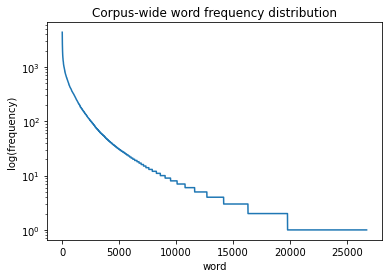

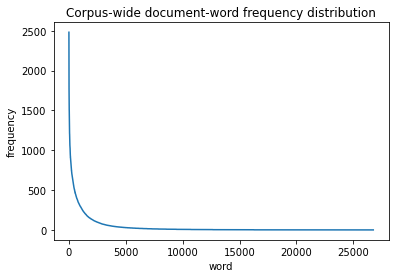

In [32]:
#print(type(list2))
_ = plotWf(list_of_authors_words_Sample_0)
_ = plotDf(list_of_authors_words_Sample_0)

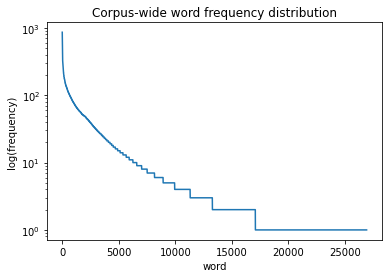

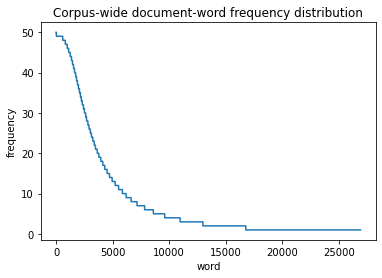

In [52]:
_ = plotWf(list_of_authors_words_Reference)
_ = plotDf(list_of_authors_words_Reference)

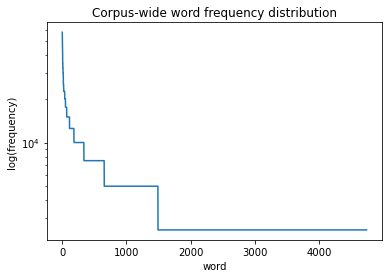

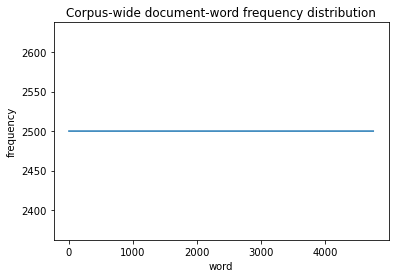

In [57]:
_ = plotWf(list_of_authors_words_Test)
_ = plotDf(list_of_authors_words_Test)

In [88]:
#print(sorted(list_of_authors_words_Test[1]))


In [65]:
#empty entry should have been remove in filterLen
#for i in range(50): #is there a better way to remove the empty entry from initializatin?
#    list_of_authors_words[0] = (list_of_authors_words[i])[1:]
#print(list_of_authors_words2[20])
#I should check I don't have any off by one effects, and also, should I sorted these lists?

pca or svd feature dimension reduction here.  Need to do them all the same way.

In [66]:
#svd = TruncatedSVD(n_components=200)
#svd.fit(mat_out)
#transformed = svd.transform(mat_out)
#print(np.shape(transformed))

In [75]:
#print(transformed[0])

This is where we now begin to prepare the data for scikitlearn

In [90]:
  #print(len(list_of_authors_words))
#mat_out_test             = build_matrix(list_of_authors_words_Test)
#mat_out_sample           = build_matrix(list_of_authors_words_Sample_0)
#mat_out_sample_by_author = build_matrix(list_of_authors_words_Reference)
  #mat_out=build_matrix(list_of_authors_words_Sample_0_3)
  #list_of_authors_words_test = list_of_authors_words[0]
  #mat_out2=namesToMatrix(list_of_authors_words_test,c-1)


In [72]:
#print(mat.shape)
mat_out_test_norm = csr_l2normalize(mat_out_test, copy=True)
print(mat_out_test_norm.shape)
csr_info(mat_out_test_norm, name="test", non_empty=True)
#
mat_out_sample_norm = csr_l2normalize(mat_out_sample, copy=True)
print(mat_out_sample_norm.shape)
csr_info(mat_out_sample_norm, name="sample", non_empty=True)
#
mat_out_sample_by_author_norm = csr_l2normalize(mat_out_sample_by_author, copy=True)
print(mat_out_sample_by_author_norm.shape)
csr_info(mat_out_sample_by_author_norm, name="sample_by_author", non_empty=True)

(2500, 4746)
test [nrows 2500 (2500 non-empty), ncols 4746 (4746 non-empty), nnz 11865000]
(2500, 27002)
sample [nrows 2500 (2500 non-empty), ncols 27002 (27002 non-empty), nnz 1123941]
(50, 26909)
sample_by_author [nrows 50 (50 non-empty), ncols 26909 (26909 non-empty), nnz 222820]


cosine similariy withavg vectors
svd
take x number of most frequently occuring elements in the vectors (eg, top 5000)

In [77]:
#print(mat_out_norm[0])
#maybe do pca first
#from sklearn import decomposition
#from sklearn import datasets
#pca = decomposition.PCA(n_components=3)
#pca.fit(mat_out)

In [ ]:
#Case 1
kmeans_test=KMeans(n_clusters=50,init='k-means++')
kmeans_test.fit(mat_out_test_norm)
labels_out_test=kmeans.labels_

#print((collections.Counter(labels_out_test)))
#print(labels.count("1"))

In [80]:
#Case 2
kmeans_sample=KMeans(n_clusters=50,init='k-means++')
kmeans_sample.fit(mat_out_sample_norm)
labels_out_sample=kmeans_sample.labels_
print((collections.Counter(labels_out_sample)))
#print(labels.count("1"))

Counter({5: 144, 32: 112, 36: 108, 21: 104, 26: 98, 11: 98, 3: 91, 46: 88, 15: 78, 42: 76, 18: 74, 16: 72, 41: 68, 30: 67, 20: 58, 6: 56, 7: 54, 40: 53, 22: 52, 49: 51, 12: 49, 25: 49, 39: 49, 1: 47, 23: 45, 2: 45, 19: 40, 8: 39, 45: 38, 9: 38, 33: 35, 10: 35, 29: 34, 17: 29, 27: 25, 35: 25, 34: 25, 28: 24, 44: 24, 0: 24, 37: 23, 43: 22, 31: 21, 48: 19, 38: 18, 47: 18, 4: 17, 14: 16, 13: 13, 24: 12})


In [81]:
#Case 3
kmeans_reference=KMeans(n_clusters=50,init='k-means++')
kmeans_reference.fit(mat_out_sample_by_author_norm)
labels_out_reference=kmeans_reference.labels_
print((collections.Counter(labels_out_reference)))
#print(labels.count("1"))

Counter({8: 1, 22: 1, 5: 1, 48: 1, 37: 1, 12: 1, 9: 1, 11: 1, 30: 1, 4: 1, 14: 1, 40: 1, 20: 1, 7: 1, 6: 1, 33: 1, 36: 1, 46: 1, 34: 1, 15: 1, 1: 1, 28: 1, 25: 1, 10: 1, 0: 1, 35: 1, 27: 1, 19: 1, 17: 1, 23: 1, 31: 1, 38: 1, 18: 1, 13: 1, 47: 1, 39: 1, 21: 1, 45: 1, 32: 1, 16: 1, 41: 1, 26: 1, 24: 1, 49: 1, 44: 1, 2: 1, 42: 1, 29: 1, 43: 1, 3: 1})


In [ ]:
#import collections


In [106]:
print(mat_out.shape)

(2500, 21968)
